In [1]:
import numpy as np
import pandas as pd
import sys
import random
from scipy.stats import entropy
import os

from sklearn import linear_model, cross_validation, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dt= pd.read_csv('merged.csv')

In [3]:
newdf=dt.dropna(subset=['DEP_DELAY'])
newdf['DepDelayed'] = dt['DEP_DELAY'].apply(lambda x: x>=15)
# newdf['DepDelayed'] = pd.Series(newdf['DepDelayed'] == True, dtype=int)
# print ("total flights: " + str(newdf.shape[0]))
# print ("total delay : ", newdf['DepDelayed'].sum())
# print ("total delay rate : ", newdf['DepDelayed'].sum()/newdf.shape[0])


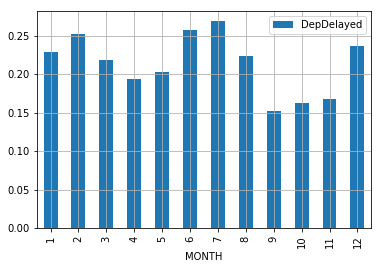

In [4]:
grouped = newdf[['DepDelayed', 'MONTH']].groupby('MONTH').mean()
grouped.plot(kind='bar')
plt.grid()

In [5]:
newdf['HOUR'] = newdf['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))

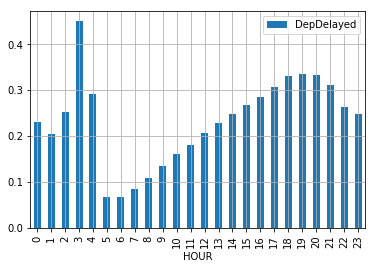

In [6]:
grouped = newdf[['DepDelayed', 'HOUR']].groupby('HOUR').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')
plt.grid()# Compute average number of delayed flights per carrier


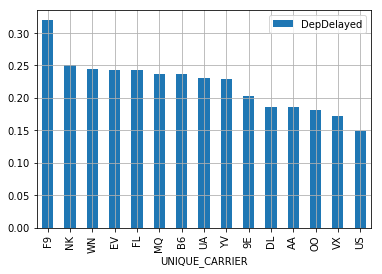

In [7]:
grouped1 = newdf[['DepDelayed', 'UNIQUE_CARRIER']].groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>10)
grouped2 = grouped1.groupby('UNIQUE_CARRIER').mean()
carrier = grouped2.sort_values(['DepDelayed'], ascending=False)

# display top 15 destination carriers by delay (from ORD)
carrier[:15].plot(kind='bar')
plt.grid()

In [8]:
newdfNC=newdf[newdf['CANCELLED']==0]

In [9]:
newdfNC = newdfNC.drop(newdfNC[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'Unnamed: 30','CANCELLATION_CODE']],axis=1)


In [10]:
newdfNC.isnull().sum()

YEAR                      0
MONTH                     0
DAY_OF_MONTH              0
DAY_OF_WEEK               0
UNIQUE_CARRIER            0
TAIL_NUM                  0
FL_NUM                    0
ORIGIN                    0
DEST                      0
CRS_DEP_TIME              0
DEP_TIME                  0
DEP_DELAY                 0
DEP_DEL15                 0
TAXI_OUT                  0
TAXI_IN                1333
CRS_ARR_TIME              0
ARR_TIME               1333
ARR_DELAY              6484
CANCELLED                 0
DIVERTED                  0
CRS_ELAPSED_TIME          1
ACTUAL_ELAPSED_TIME    6484
AIR_TIME               6484
DISTANCE                  0
DepDelayed                0
HOUR                      0
dtype: int64

In [11]:
newdfNC=newdfNC.dropna(how='any')

In [12]:
newdfNC.loc[newdfNC['DEP_DELAY'] <= -5, 'delay_level'] = 1
newdfNC.loc[(newdfNC['DEP_DELAY'] >-5 ) & (newdfNC['DEP_DELAY'] < 15), 'delay_level'] = 2
newdfNC.loc[newdfNC['DEP_DELAY'] >= 15 , 'delay_level'] = 3

#newdfNC['delay_level'].shape
newdfNC['delay_level']=newdfNC['delay_level'].astype(int)

In [15]:
newdfNC['delay_level']
len(newdfNC[newdfNC['delay_level']==1])

589427

In [13]:
newdfNC.isnull().sum()

YEAR                   0
MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
UNIQUE_CARRIER         0
TAIL_NUM               0
FL_NUM                 0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
DEP_DEL15              0
TAXI_OUT               0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
DepDelayed             0
HOUR                   0
delay_level            0
dtype: int64

In [ ]:
# grouped = newdfNC[['DepDelayed', 'delay_level']].groupby('delay_level')

# # plot average delays by hour of day
# grouped.plot(kind='bar')
# plt.grid()# Compute average number of delayed flights per carrier


In [21]:
len(newdfNC[newdfNC['delay_level']==1])

589427

In [17]:
len(newdfNC['delay_level']==2)

2036850

In [14]:
distribution=pd.DataFrame({'number of flights':[len(newdfNC[newdfNC['delay_level']==1]),len(newdfNC[newdfNC['delay_level']==2]),len(newdfNC[newdfNC['delay_level']==3])],
                           'delay level': [1,2,3]})

In [15]:
distribution['number of flights']

0     589427
1    1014399
2     433024
Name: number of flights, dtype: int64

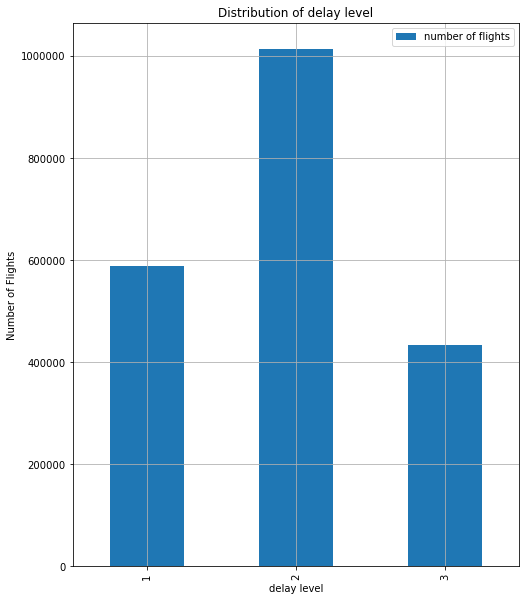

In [16]:
#plt.figure(figsize=(30,20))
#distribution.plot(x='delay level',y='number of flights',kind='bar',title='Distribution of delay level')
distribution.plot(x='delay level',y='number of flights',kind='bar',figsize=(8,10),title='Distribution of delay level').set_ylabel("Number of Flights")
plt.grid()
plt.savefig('distribution.png')

In [49]:
newdfNC.groupby('ORIGIN').get_group('JFK')

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,...,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DepDelayed,HOUR,delay_level
727,2015,1,1,4,MQ,N824MQ,3225,JFK,DCA,1110,...,-7.0,0.0,0.0,73.0,72.0,47.0,213.0,0,11,1
728,2015,1,2,5,MQ,N833MQ,3225,JFK,DCA,1110,...,33.0,0.0,0.0,73.0,80.0,51.0,213.0,1,11,3
729,2015,1,3,6,MQ,N826MQ,3225,JFK,DCA,1110,...,35.0,0.0,0.0,73.0,109.0,65.0,213.0,0,11,2
730,2015,1,4,7,MQ,N812MQ,3225,JFK,DCA,1110,...,5.0,0.0,0.0,73.0,84.0,64.0,213.0,0,11,1
731,2015,1,5,1,MQ,N830MQ,3225,JFK,DCA,1110,...,-6.0,0.0,0.0,73.0,70.0,50.0,213.0,0,11,2
732,2015,1,6,2,MQ,N826MQ,3225,JFK,DCA,1110,...,68.0,0.0,0.0,76.0,107.0,46.0,213.0,1,11,3
735,2015,1,9,5,MQ,N814MQ,3225,JFK,DCA,1110,...,48.0,0.0,0.0,76.0,109.0,55.0,213.0,1,11,3
736,2015,1,10,6,MQ,N671MQ,3225,JFK,DCA,1110,...,-18.0,0.0,0.0,76.0,68.0,43.0,213.0,0,11,1
737,2015,1,11,7,MQ,N814MQ,3225,JFK,DCA,1110,...,5.0,0.0,0.0,76.0,84.0,48.0,213.0,0,11,2
738,2015,1,12,1,MQ,N830MQ,3225,JFK,DCA,1110,...,-4.0,0.0,0.0,76.0,79.0,48.0,213.0,0,11,1


## 2. data preparation

In [17]:
X = newdfNC[['UNIQUE_CARRIER','ORIGIN', 'DEST']]
X2 = pd.get_dummies(X)

In [18]:
Fdata=pd.concat([newdfNC,X2],axis=1)


In [19]:
data=Fdata.drop(Fdata[['YEAR', 'DAY_OF_MONTH', 'FL_NUM', 'TAXI_OUT','TAXI_IN','ARR_DELAY','DIVERTED','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME','DepDelayed','FL_NUM','ARR_TIME','CANCELLED','TAIL_NUM','CRS_DEP_TIME','DEP_TIME','DEP_DELAY','CRS_ARR_TIME','ORIGIN','UNIQUE_CARRIER','DEST','DEP_DEL15']],axis=1)

In [ ]:
# Y = data['delay_level']
# X = data.drop('delay_level', 1)
# dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
# dtc.fit(X, Y)

In [ ]:
# from sklearn.cross_validation import train_test_split
# X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.25, random_state=1)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [22]:
lr = LogisticRegression(C=0.01)
dtree = DecisionTreeClassifier()
etree = ExtraTreesClassifier(n_estimators=100, min_samples_split=200)
rf = RandomForestClassifier(n_estimators=30, min_samples_split=300)
svc = SVC(C=0.01)
knn = KNeighborsClassifier()
#xg= XGBClassifier()

In [23]:
msk = np.random.rand(len(data)) < 0.25
Train_data = data[msk]
Test_data = data[~msk]

In [82]:
def quick_test_model(data, model, eval_metrics):
    """
    Run a quick test on the model, reports the metrics
    """
    all_labels = np.unique(np.concatenate([data[2],data[3]]))
    model.fit(data[0], data[2])
    need_density_estimation = [log_loss]
    if eval_metrics in need_density_estimation:
        pred_train = model.predict_proba(data[0])
        pred_test = model.predict_proba(data[1])
        train_loss = eval_metrics(data[2],pred_train, labels=all_labels)
        test_loss = eval_metrics(data[3],pred_test, labels=all_labels)
    else:
        pred_train = model.predict(data[0])
        pred_test = model.predict(data[1])
        train_loss = eval_metrics(data[2],pred_train)
        test_loss = eval_metrics(data[3],pred_test)
    return [train_loss, test_loss, pred_train, pred_test]

In [83]:
lr = LogisticRegression(C=0.01)
dtree = DecisionTreeClassifier()
etree = ExtraTreesClassifier(n_estimators=100, min_samples_split=200)
rf = RandomForestClassifier(n_estimators=30, min_samples_split=300)
svc = SVC(C=0.01)
knn = KNeighborsClassifier()

In [84]:
def modBootstrapper(train, test, nruns, sampsize):
    
    for i in range(nruns):
        train_sample = train.iloc[np.random.randint(0,len(train), size=sampsize)]
        x_train=train_sample.drop('delay_level', 1)
        y_train=train_sample['delay_level']
        x_test=test.drop('delay_level',1)
        y_test=test['delay_level']
    return [x_train,x_test,y_train, y_test]

In [85]:
LR_model=modBootstrapper(Train_data, Test_data, 5, 50000) 

In [95]:
LR_model

[         MONTH  DAY_OF_WEEK  AIR_TIME  DISTANCE  HOUR  UNIQUE_CARRIER_9E  \
 37837        1            5      39.0     184.0    18                  0   
 106793      11            5     130.0    1076.0    16                  0   
 1746570      2            1      87.0     712.0    15                  0   
 1920842      6            1     137.0    1096.0    10                  0   
 403573       7            3     325.0    2475.0     7                  0   
 211644       3            3     293.0    2475.0    10                  0   
 1836909      4            1     109.0     762.0     7                  0   
 1809724      3            5      75.0     473.0    16                  0   
 644353      12            4      76.0     563.0     9                  0   
 1288830      5            3     138.0    1069.0    14                  0   
 568616      10            6     225.0    1620.0    15                  0   
 297705       4            7      52.0     289.0    13                  0   

In [86]:
quick_test_model(LR_model,lr,accuracy_score)

[0.52044000000000001,
 0.51977184420263289,
 array([1, 2, 2, ..., 2, 2, 2]),
 array([2, 2, 2, ..., 2, 2, 1])]

In [107]:
LR_model=modBootstrapper(Train_data, Test_data, 5, 50000) 

In [111]:
quick_test_model(LR_model,lr,accuracy_score)[1]

0.51997475990490449

In [ ]:
nruns=5
test_loss=[]
train_loss=[]
for i in range(nruns):
    sampledata=modBootstrapper(Train_data, Test_data, 5, 50000) 
    test_loss.append(quick_test_model(sampledata,knn,accuracy_score)[1])
    train_loss.append(quick_test_model(sampledata,knn,accuracy_score)[0])
test_loss_mean = np. mean(test_loss)
train_loss_mean = np.mean(train_loss)
# pred_train = quick_test_model(sampledata,lr,accuracy_score)[2]
# pred_test = model.predict(quick_test_model(sampledata,lr,accuracy_score)[3])
aucs=[test_loss_mean, train_loss_mean]        


In [122]:
aucs

[0.52681773195228465, 0.54242400000000013]

In [ ]:
LR_model=modBootstrapper(Train_data, Test_data, 2, 50000) 
quick_test_model(LR_model,lr,accuracy_score)

In [110]:
# from sklearn.metrics import accuracy_score
# def modBootstrapper(train, test, nruns, sampsize,model):
#     aucs=[]
#     need_density_estimation = [log_loss]
#     for i in range(nruns):
#         train_sample = train.iloc[np.random.randint(0,len(train), size=sampsize)]
# #         x_train=train_sample.drop('delay_level', 1)
# #         y_train=train_sample['delay_level']
# #         x_test=test.drop('delay_level',1)
# #         y_test=test['delay_level']
# #         x_train.append(train_sample.drop('delay_level', 1))
# #         y_train.append(train_sample['delay_level'])
# #         x_test.append(test.drop('delay_level',1))
# #         y_test.append(test['delay_level'])    
# #     quick_test_model(x_train, x_test,y_train,y_test,model,eval_metrics)
# #     aucs=np.mean(quick_test_model()[test_loss])
        
#         if model==svm: 
#             clf=SVC(C=0.01)
#             clf.fit(train_sample.drop('delay_level', 1),train_sample['delay_level'])
            
#             if eval_metrics in need_density_estimation:
#                 pred_train = model.predict_proba(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict_proba(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train, labels=all_labels)
#                 test_loss = eval_metrics(test['delay_level'],pred_test, labels=all_labels)
#             else:
#                 pred_train = model.predict(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train)
#                 test_loss = eval_metrics(test['delay_level'],pred_test)  
#         if model==lr: 
#             logmodel = LogisticRegression(C=1e30)
#             logmodel.fit(train_sample.drop('delay_level', 1),train_sample['delay_level'])#t to logistic regression model according to the given training data
            
#             if eval_metrics in need_density_estimation:
#                 pred_train = model.predict_proba(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict_proba(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train, labels=all_labels)
#                 test_loss = eval_metrics(test['delay_level'],pred_test, labels=all_labels)
#             else:
#                 pred_train = model.predict(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train)
#                 test_loss = eval_metrics(test['delay_level'],pred_test) 
#         if model==dtree:
#             dtree= DecisionTreeClassifier()
#             dtree.fit(train_sample.drop('delay_level', 1),train_sample['delay_level']
#             if eval_metrics in need_density_estimation:
#                 pred_train = model.predict_proba(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict_proba(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train, labels=all_labels)
#                 test_loss = eval_metrics(test['delay_level'],pred_test, labels=all_labels)
#             else:
#                 pred_train = model.predict(train_sample.drop('delay_level', 1))
#                 pred_test = model.predict(test.drop('delay_level',1))
#                 train_loss = eval_metrics(train_sample['delay_level'],pred_train)
#                 test_loss = eval_metrics(test['delay_level'],pred_test) 
#     test_loss_mean = np. mean(test_loss)
#     train_loss_mean = np.mean(train_loss)
#     pred_train = model.predict(x_train)
#     pred_test = model.predict(x_test)
#     aucs=[test_loss_mean, train_loss_mean]        
#     return aucs

SyntaxError: invalid syntax (<ipython-input-110-3503a6bb848b>, line 49)

In [69]:
LR_model=modBootstrapper(Train_data, Test_data, 2, 50000) 

In [70]:
LR_model

[[         MONTH  DAY_OF_WEEK  AIR_TIME  DISTANCE  HOUR  UNIQUE_CARRIER_9E  \
  305904       5            5      84.0     544.0    17                  0   
  76459       10            4     141.0    1010.0    15                  0   
  1932310      6            2      79.0     502.0    12                  0   
  1705706     12            3     130.0     738.0    17                  0   
  1508817      6            5     308.0    2475.0     9                  0   
  1198081      3            2     177.0    1074.0    20                  0   
  1815630      4            7      88.0     479.0    11                  0   
  998500       9            2     266.0    2248.0    22                  0   
  852597       6            3      80.0     541.0    13                  0   
  209156       2            6      84.0     717.0    20                  0   
  562761       1            1      54.0     277.0    10                  0   
  384388       6            3     146.0    1076.0    10         

In [28]:
svm_model=modBootstrapper(Train_data, Test_data, 1, 10000, 1) 

In [30]:
svm_model

[0.49637871849053045, 0.0]

In [20]:
data.shape

(2036850, 260)

In [70]:
LR_model

[0.52285230251185488, 0.00045734476631872337]

## feature importance ranking##

In [24]:
Y = data['delay_level']
X = data.drop('delay_level', 1)
dtc = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dtc.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [26]:
feature_mi = dtc.feature_importances_


259


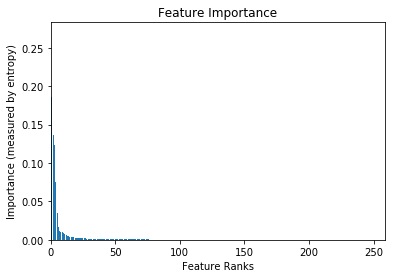

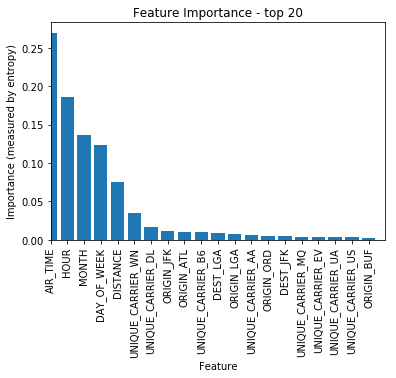

In [28]:
top_k = 20
feature_importance =feature_mi.tolist()
print(len(feature_importance))
feature_num =len(feature_importance)
importance_list = np.sort(feature_importance)[::-1]
idx_list = np.argsort(feature_importance)[::-1] 
top_k_importance = importance_list[:top_k]
top_k_features_idx = idx_list[:top_k]
top_k_features = [X.columns[i] for i in top_k_features_idx]
# plot feature importane distribution
plt.bar(range(feature_num), importance_list , align='center')
plt.xlim((0,feature_num))
plt.title("Feature Importance")
plt.ylabel("Importance (measured by entropy)")
plt.xlabel("Feature Ranks")
plt.savefig('feature importance ranks.png')
plt.show()
# plot top k features
plt.bar(range(top_k), top_k_importance , align='center')
plt.xticks(range(top_k), top_k_features, rotation='vertical')
plt.xlim((0,top_k))
plt.title("Feature Importance - top {0}".format(top_k))
plt.ylabel("Importance (measured by entropy)")
plt.xlabel("Feature")
plt.savefig('top 20 feature .png')
plt.show()

In [31]:
'''126 feature after decay'''
feature_mi=feature_mi[(feature_mi>10**-4)]
feature_mi.size

126

In [35]:
'''top 30 features and feature importance'''
#feature_mi_dict = dict(zip(feature_mi,X.columns.values))
feature_mi_dict = zip(feature_mi,X.columns.values)
feature_sort = sorted(feature_mi_dict )
feature_sort[:-(30+1):-1]

[(0.26966861033989692, 'AIR_TIME'),
 (0.18635303335915668, 'HOUR'),
 (0.13619850291819094, 'MONTH'),
 (0.12280717802681354, 'DAY_OF_WEEK'),
 (0.07545117585695521, 'DISTANCE'),
 (0.034444859221097114, 'UNIQUE_CARRIER_VX'),
 (0.017210804875208572, 'UNIQUE_CARRIER_B6'),
 (0.010992074432655909, 'ORIGIN_CHS'),
 (0.010764051522752675, 'ORIGIN_ABQ'),
 (0.0098997822541013782, 'UNIQUE_CARRIER_AS'),
 (0.0084609659412004604, 'ORIGIN_MYR'),
 (0.0076514576623523331, 'ORIGIN_CMH'),
 (0.0067254473594431114, 'UNIQUE_CARRIER_AA'),
 (0.0049069313614919169, 'ORIGIN_DSM'),
 (0.004389505398247096, 'ORIGIN_MSY'),
 (0.0042066785698726596, 'UNIQUE_CARRIER_HA'),
 (0.00395412252584584, 'UNIQUE_CARRIER_DL'),
 (0.0037824364722808023, 'UNIQUE_CARRIER_OO'),
 (0.0035391644118453417, 'UNIQUE_CARRIER_UA'),
 (0.0027218343243768299, 'ORIGIN_AUS'),
 (0.0026799470743820129, 'ORIGIN_MDT'),
 (0.002616252922217315, 'ORIGIN_BOS'),
 (0.0025467944497683582, 'ORIGIN_GSP'),
 (0.0023017597381532104, 'ORIGIN_BUF'),
 (0.002198872154

## bulid model##

## Method 1 select 50000 sample of data ##

In [37]:
msk = np.random.rand(len(data)) < 0.25
Train_data = data[msk]
Test_data = data[~msk]

In [38]:
def quick_test_model(data, model, eval_metrics):
    """
    Run a quick test on the model, reports the metrics
    """
    all_labels = np.unique(np.concatenate([data[2],data[3]]))
    model.fit(data[0], data[2])
    need_density_estimation = [log_loss]
    if eval_metrics in need_density_estimation:
        pred_train = model.predict_proba(data[0])
        pred_test = model.predict_proba(data[1])
        train_loss = eval_metrics(data[2],pred_train, labels=all_labels)
        test_loss = eval_metrics(data[3],pred_test, labels=all_labels)
    else:
        pred_train = model.predict(data[0])
        pred_test = model.predict(data[1])
        train_loss = eval_metrics(data[2],pred_train)
        test_loss = eval_metrics(data[3],pred_test)
    return [train_loss, test_loss, pred_train, pred_test]

In [39]:
def modBootstrapper(train, test,sampsize):
    train_sample = train.iloc[np.random.randint(0,len(train), size=sampsize)]
    x_train=train_sample.drop('delay_level', 1)
    y_train=train_sample['delay_level']
    x_test=test.drop('delay_level',1)
    y_test=test['delay_level']
    
    return [x_train,x_test,y_train, y_test]

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [45]:
lr = LogisticRegression(C=0.01)
dtree = DecisionTreeClassifier()
etree = ExtraTreesClassifier(n_estimators=100, min_samples_split=200)
rf = RandomForestClassifier(n_estimators=30, min_samples_split=300)
svc = SVC(C=0.01)
knn = KNeighborsClassifier()
MultiNB= MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
BNB=BernoulliNB()
#xg= XGBClassifier()

In [ ]:
'''run model for 5 times to get test accuracy'''
nruns=5
test_loss=[]
train_loss=[]
for i in range(nruns):
    sampledata=modBootstrapper(Train_data, Test_data, 50000) 
    test_loss.append(quick_test_model(sampledata,MultiNB,accuracy_score)[1])
    train_loss.append(quick_test_model(sampledata,MultiNB,accuracy_score)[0])
test_loss_mean = np. mean(test_loss)
train_loss_mean = np.mean(train_loss)
# pred_train = quick_test_model(sampledata,lr,accuracy_score)[2]
# pred_test = model.predict(quick_test_model(sampledata,lr,accuracy_score)[3])
aucs=[test_loss_mean, train_loss_mean]        


## Method 2 run all 200w+ data

In [58]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.25, random_state=1)

In [59]:
def quick_test_model_all(x_train, x_test, y_train, y_test, model, eval_metrics):
    """
    Run a quick test on the model, reports the metrics
    """
    all_labels = np.unique(np.concatenate([y_train,y_test]))
    model.fit(x_train, y_train)
    need_density_estimation = [log_loss]
    if eval_metrics in need_density_estimation:
        pred_train = model.predict_proba(x_train)
        pred_test = model.predict_proba(x_test)
        train_loss = eval_metrics(y_train,pred_train, labels=all_labels)
        test_loss = eval_metrics(y_test,pred_test, labels=all_labels)
    else:
        pred_train = model.predict(x_train)
        pred_test = model.predict(x_test)
        train_loss = eval_metrics(y_train,pred_train)
        test_loss = eval_metrics(y_test,pred_test)
    return [train_loss, test_loss, pred_train, pred_test]

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

In [43]:
# models
lr = LogisticRegression(C=0.01)
dtree = DecisionTreeClassifier()
etree = ExtraTreesClassifier(n_estimators=100, min_samples_split=200)
rf = RandomForestClassifier(n_estimators=30, min_samples_split=300)
#svc = SVC(C=0.01)
knn = KNeighborsClassifier()
MultiNB= MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
BNB=BernoulliNB()
Run Model
dtree.fit(X_train, Y_train)
train_acc, test_acc, pred_train, pred_test = quick_test_model_all(X_train, X_test, Y_train, Y_test, rf, accuracy_score)
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, lr, accuracy_score))
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, dtree, accuracy_score))
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, etree, accuracy_score))
#print(quick_test_model_all(X_train, X_test, Y_train, Y_test, svc, accuracy_score))
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, knn, accuracy_score))
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, MultiNB, accuracy_score))
print(quick_test_model_all(X_train, X_test, Y_train, Y_test, BNB, accuracy_score))
print(train_acc, test_acc)

## method 3 ##

In [1]:
'''use method model.predict() and ccuracy score to calculate y-pred and y——true'''

SyntaxError: EOL while scanning string literal (<ipython-input-1-9d97375e24dd>, line 1)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score # we can also call these func by metrics.roc_curve
c_logmodel=LogisticRegression().fit(X_train, Y_train)
#c_prd_logmodel= c_logmodel.predict_proba(X_test)[:,1]
#LogisticRegression(solver='newton-cg')
Y_pred=c_logmodel.predict(X_test)

In [30]:
'''LR '''
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.52397915999787903

In [31]:
Y_pred[:1000]

array([2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 3, 2, 2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 1, 3, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2,
       3, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 1, 2, 1, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 1, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2,
       1, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2,

In [32]:
len(Y_pred)

509213

In [33]:
'''multiM+NB'''
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, Y_train)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
print(accuracy_score(Y_test,clf.predict(X_test)))

0.458258135594


In [34]:
clf.predict(X_test)[:100]

array([2, 2, 2, 2, 3, 2, 2, 1, 1, 1, 2, 2, 3, 2, 2, 3, 3, 2, 3, 1, 2, 2, 3,
       3, 2, 2, 2, 1, 1, 1, 2, 3, 1, 2, 3, 1, 1, 2, 3, 2, 3, 3, 2, 2, 2, 2,
       1, 1, 3, 2, 2, 3, 1, 3, 2, 2, 3, 1, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2,
       2, 2, 3, 1, 2, 2, 3, 1, 1, 1, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3,
       1, 3, 1, 1, 3, 1, 2, 3])

In [35]:
'''BNB'''
from sklearn.naive_bayes import BernoulliNB
clf1= BernoulliNB()
clf1.fit(X_train,Y_train)
print(accuracy_score(Y_test,clf1.predict(X_test)))

0.510617364443


In [36]:
clf1.predict(X_test)[10382:10500]

array([1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 1, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1,
       1, 2, 2])

In [39]:
'''Random Guess'''
y_rg=np.random.randint(low=1,high=4,size=len(Y_test))

In [40]:
print(accuracy_score(Y_test,y_rg))

0.145051285022


## cross validation##

In [46]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn import base
from sklearn.model_selection import KFold
%matplotlib inline

In [48]:
def plot_cross_validation(y_data, x_data, model_name, param_name, y_axis="Accuracy"):
    plt.figure()
    plt.title("Cross Validation Curve for {0}".format(model_name))
    plt.xlabel(param_name)
    plt.ylabel(y_axis)
    plt.grid()
    mean, std = y_data
    plt.fill_between(x_data, mean - std, mean + std, alpha=0.1, color="g")
    plt.plot(x_data, mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()
def compute_cross_validation_data(model, sampledata, param_name, param_list, eval_metrics, k_fold=5):
    """
    Function that shows plot for tunning
    """
    kf = KFold(n_splits=k_fold)
    mean_train = []
    mean_test = []
    std_train = []
    std_test = []
    all_idx = range(len(sampledata[0]))
    for param in param_list:
        current_train = []
        current_model = base.clone(model)
        param_dict={param_name:param}
        current_model.set_params(**param_dict)
        current_test = cross_val_score(current_model, sampledata[0], sampledata[2])
        #for train_idx, test_idx in kf.split(all_idx):
            #current_model = base.clone(model)
            #param_dict={param_name:param}
            #current_model.set_params(**param_dict)
            #train_loss, test_loss = quick_test_model(x_train[train_idx], x_train[test_idx], y_train[train_idx], y_train[test_idx],
            #                        current_model, eval_metrics)
            #current_train.append(train_loss)
            #current_test.append(current_test)
        #mean_train.append(np.mean(current_train))
        mean_test.append(np.mean(current_test))
        #std_train.append(np.std(current_train))
        std_test.append(np.std(current_test))
    #return [mean_train, mean_test, std_train, std_test]
    return [ np.array(mean_test), np.array(std_test)]
                

In [49]:
sampledata=modBootstrapper(Train_data, Test_data, 5, 50000)
param_name = "min_samples_split"
param_domain = [5,10,20,30,40,50,60,70,80,90,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1200,1400,1600,1800,2000,2200,2400]

In [64]:
'''rf'''
cv_data = compute_cross_validation_data(rf, sampledata, param_name, param_domain, accuracy_score)
best_idx = np.argmax(cv_data[0])
print("Best param found at {0}={1} with acc={2}".format(param_name, param_domain[best_idx], cv_data[0][best_idx]))


Best param found at min_samples_split=80 with acc=0.5335200196272085


In [56]:
max(cv_data[0])

0.52966001289439635

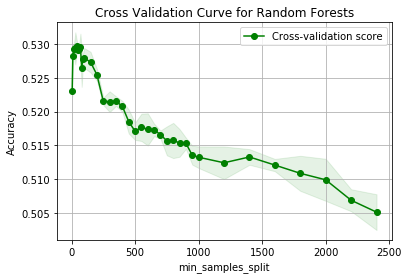

In [63]:
plot_cross_validation(cv_data, param_domain, "Random Forests", param_name, y_axis="Accuracy")
plt.savefig('CV curve for Random Forests.png')
plt.show()

In [ ]:
'''dtree'''
cv_data = compute_cross_validation_data(dtree, sampledata, param_name, param_domain, accuracy_score)
plot_cross_validation(cv_data, param_domain, "Decision Tree", param_name, y_axis="Accuracy")
best_idx = np.argmax(cv_data[0])
print("Best param found at {0}={1} with acc={2}".format(param_name, param_domain[best_idx], cv_data[0][best_idx]))


In [ ]:
'''etree'''
cv_data = compute_cross_validation_data(etree, X_train, Y_train, param_name, param_domain, accuracy_score)
plot_cross_validation(cv_data, param_domain, "Extra Random Tree", param_name, y_axis="Accuracy")
best_idx = np.argmax(cv_data[0])
print("Best param found at {0}={1} with acc={2}".format(param_name, param_domain[best_idx], cv_data[0][best_idx]))


In [93]:
'''lr'''
scores = cross_val_score(lr, sampledata[1], sampledata[3], cv=5)
print("Accuracy: %0.5f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.52120 (+/- 0.00)


In [92]:
'''knn'''
scores = cross_val_score(knn, sampledata[1], sampledata[3], cv=5)
print("Accuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.47 (+/- 0.00)


## plot learning curve##

In [ ]:
msk = np.random.rand(len(data)) < 0.25
Train_data = data[msk]
Test_data = data[~msk]

In [73]:

# x_train=Train_data[:20000].drop('delay_level', 1)
# y_train=Train_data[:20000]['delay_level']
# x_test=Test_data.drop('delay_level',1)
# y_test=Test_data['delay_level']
x_train=sampledata[0]
x_test=sampledata[1]
y_train=sampledata[2]
y_test=sampledata[3]
len(x_train)

50000

In [67]:
def plot_learning_curve_multiple(data, x_val, ylabel="ACC"):
    """
    Function that plots multiple lines with mean & std
    @param data: data[model_name][x_val]=[all data]
    """
    plt.figure()
    plt.title("Learning Curve - Model Comparison")
    plt.xlabel("Training examples")
    plt.ylabel(ylabel)
    
    for model_name in data:
        y_mean = []
        y_std = []
        for x in x_val:
            y_mean.append(np.mean(data[model_name][x]))
            y_std.append(np.std(data[model_name][x]))
        plt.errorbar(x_val, y_mean, yerr=y_std, label=model_name)
    plt.legend()
    plt.show()

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 8),
                       metrics=accuracy_score):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=make_scorer(metrics), cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [78]:
def compute_learning_curve_multiple(model_dict, x_train,y_train, metrics, chunks, rep=10):
    """
    Plot out-of-sample learning curve against each models
    @param model_dict " {name -> models}
    """
    # model_performance[model_name][chunk_i]=[]
    model_performance = {}
    for chunk in chunks:
        for i in range(rep):
            # shuffle every iteration
            train_idx = list(range(len(x_train)))
            np.random.shuffle(train_idx)
            train_idx = train_idx[:chunk]
            current_train_x = x_train[train_idx]
            current_train_y = y_train[train_idx]
            for model_name in model_dict:
                if model_name not in model_performance:
                    model_performance[model_name] = {}
                if chunk not in model_performance[model_name]:
                    model_performance[model_name][chunk]=[]
                train_score, test_score,_,_ = quick_test_model(current_train_x, x_test, 
                                                                      current_train_y, y_test, 
                                                                      model_dict[model_name], metrics)
                model_performance[model_name][chunk].append(test_score)
    return model_performance

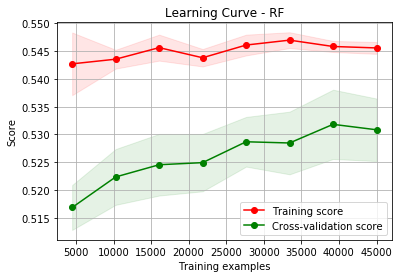

TypeError: compute_learning_curve_multiple() takes from 5 to 6 positional arguments but 7 were given

In [69]:
# learning curve
curve_plot = plot_learning_curve(rf, "Learning Curve - RF", x_train, y_train, cv=10)
curve_plot.show()

# compare model
x_val = [1000,2000,3000]
model_dict = {"LR":lr, "dt":dtree}#
res = compute_learning_curve_multiple(model_dict, x_train, y_train, accuracy_score, x_val)
plot_learning_curve_multiple(res, x_val)


In [91]:
# compare model
# from sklearn.cross_validation import train_test_split
# X_train, X_test, Y_train, Y_test =train_test_split(X, Y, test_size=0.25, random_state=1)
x_train=data[:50000].drop('delay_level', 1)
y_train=data[:50000]['delay_level']
# x_test=Test_data.drop('delay_level',1)
# y_test=Test_data['delay_level']
x_val = [1000,2000,3000]
model_dict = {"LR":lr, "dt":dtree}#
res = compute_learning_curve_multiple(model_dict, x_train, y_train, accuracy_score, x_val)
plot_learning_curve_multiple(res, x_val)


KeyError: '[19523 40918 48299 31241   660 31264 41661 25212 17224 17900 25059  8121\n 15038    18 14218 47991 12845 11578 43736 38260 10330 25636 19612 48665\n 11254  8435 48859 42389 11763 30529 13764 47756 28031 17611 28574  6550\n 11169 45123 45681  4253 40343 28557 41636 19295 13152 37673  6390 49158\n 15351 19550 27860 14942 19141 42872 42802  8039 11766 49938 41643 14386\n  4371 12342 33172  3917 33438 32167   105  3948 25295 42814  6619  5700\n 49820 40171 41849 32855   484 24523 19339 27969 40286 44369 32345   677\n 38435 11251 17638 32725  7752 43994 41842 21329 42756  3163 36703 15947\n 43037 13897 30455 42972 28867 16172 46584 43234 40897 48187 38976 49062\n 23827  7265 14881  4278 46876 47084  9927 33824  2828 36850 25234 23535\n  9316 30341 21435 22871  6771 22647 26300  1300 37543 41877   843  1045\n  8432 15186 46699 19004 17424 34123 19675  4338 25925 48462 42889 28815\n 32880 30422 30742 40635 33427 38610 10926 18095 34344 20117 44231  7357\n 30137 44087 20162 49569 12457  6270 48677 32840 27630 10913 18635 19299\n 31965 14640 27410 22474 13628 22726 40433 20391 40727  5958 32983 33184\n 15497 47514 11409 45934 41682 24590 33019   666 18094 34288 26107  3505\n  9535 34390 40935 16079  9327 20024 15020 32029 49234 43348 21838  1025\n  1325 34389 34092 32502  1735 24304 19586  6633  8765 30222 15387 48551\n 40679  7014 43647 38110 31979 46111  2302 32032 29917 32261 42392 36813\n 34192 34239 13913 38073 41136  6408 19819 12706 47653 35880 29908 11640\n 10375 46084 47225 44183  4784 15389 32113 45554  6389 46971 48212 32036\n  1745 35280 17719  1017 30355 11240  1168 21592 19881  3726 32728 34172\n  9539 36734 41420 23715 29962 45057 37167 18887 30021 35382 41651 29839\n 34896  2006 32597 23085  8329  9786  6181  6818 21506  7901 41124 44590\n 43674 19578 37276 44166 36480 49213 11278 16885 42054 28696 11190 37941\n 14517 48298 16382 43595  3106 10672 13225 27945 26393 40453 42247 36663\n 28621 43790 40240 43175 14391 42799 14606  2692 32147   994  6528 19103\n 45324 38386 23900 45875 28614  9314  4665 33624  4958  1320 43276 30818\n  8500 34922 49119 44387 47088 26813 47533 10315 38016  2309 27422  7873\n 34439 18311 20537 34713 10183 44557 16023 41447 17028  6503 40786 37114\n 24910 43766 40592 44591 13893 48122 23885 46181 31517 39050 38734 32362\n 22064  7771 29423 35101 24430 18306 10807  8104 48011 44378 39772 11745\n  9569 26551 34755 22929 48866 37810 32576 22502  6202  2684   926 28654\n 41129  8714  3160 18187  5719 47570 47821 18384 36163  9018 17304 43922\n 12506 40700 37459 48889 33522  1883 27696 39792 41735 24143 16435  5198\n  2893 19460  4967 36775 21602 33242 25318 39494 31136  8070 42874 48631\n 25513  1380 49458 42360 14568 36588  3332 21202 41458 27914 37809  2240\n 38341 14020  2566 36622 27622  3685 18104 20561 38246 24232 26190 13000\n 14042 17322 26174 31200 14815 42396 46885 29067 31759  3656  4326 35491\n 23197 47176 43222 41557 13896 26380  3612 19324 27309 41081 34443 28592\n 23301 18226  8258 25941 45349 44873 31409 34907 19690 45700 28517 25780\n 27502 41953 46785 21775 11046 30842 44200 28180 29404 36935  3477 34687\n 49936 35255 26728 43311  5564 29110 46207 39960 30690  9656 30853 14586\n  9758 32065 23602 32705 39066 10863 40893 29261  8854 48538 47221 12295\n 16130 24732  7674 40218 14021 49015 25945 40324 42762 30919   544 35035\n  7788 19976 38477  4638 20456 10184 15955 42116 32107 23377  2022  9596\n 44023  3865 46559 25018 26096 32398 23639 21708 49593 20278  4611 37090\n 28724 38165 14344 29655 37396 31977  3893  2144  3363 13747 37757 46457\n 38754 25716 14217 45958 21363 33259 24009 12828 38293  8097 25352 39851\n 36796 28893 28349 29371 22907 49964 39218 26611  6095 16762  3293  1518\n 40091 33773 32554 44612 39129 46748 16004 29763 24356 22110  5430 25297\n  6916  1261 26489 23898 49920 40903 46124 49578 48621 15906 48061 22366\n  8021 19535 23603 23958 48935  1126 26862 33848 24860  9176  2970 28371\n  3075 19743 14225 29918 18056 16497  5447 14047 25627 30086 30414 11602\n 33433 41787 22373 19318 40083 35854 46723   966 10363 34117  4542 36374\n 27548  7425 37700  6154 24134  7174 28230 38288 29959 38159 18705 27789\n 46901 37060 30557  7142  4892 21275  8394 45070 41040 25572 25591 23797\n 34089  7661 22224 25326 43896 13569  3499 13677 46769 16241 46231 31259\n  4165 15914 39579  3757 36582 24535  1802 38469 34660 18475  5262 22458\n 27513  9510 42749  7718 30689 38285  4646 43039 16098 11684 36217 40916\n 19263 14700 45942 11868  2543  7534 20126 29850 43136 48446 27081 36079\n 32152   633    85  1489 18064  8693 12997 40605 46412 26201 27274 28378\n 32367 34338 21218 20716  5721 35339 10105  1156 27353 23091 14413 45165\n 19585 16222 40183 22990 10150 36925 43316  6411 32045 23876 48900 12690\n 41016 15108 42282 47477  1335 47407 38805 36188 32209 34718 34264 28490\n  4667 23037 23638 35982 35835 28995 47955 37172 44020 43061 39921 27349\n 11757 46855 35652    72  2218  5261 42492 41214 43708 21092 28462   807\n  5798  2720  9443 43064 38839 30195  8025 18999 31803 30451  9672 27523\n 27725 16740 19759 39573 21063 40968 25632 14539  7746 26559  8092 29496\n  3031 19867 46152 15205 33990  4545 34177   508  7842 10699 19979 20296\n 15852 21740 42562  4934 13027 41086 17803 36244 49681 13307  4629 28075\n 34528 32559 23442 15582 48125 12809  7767  7964 12755 43241 31588 16811\n  1118 24372 23790  8901 31097 43631 27644 48014  6333 27858 18517  3348\n 28570 12375 17046  5358 16914 29745 25269 34302 32279 16120 19909  4001\n  8948  2741 19402 39923 38456 39540 14964 44887 48570 30039  4579 45689\n 28292 31566 27636 17145 23284 22557 32090 43871 32930 24127 30754 26422\n 19154 18989 29719 11236 10717 26385 16771 18462 36897 33093 16039  3331\n 36788 11420 42236 48635 15048 41934 16590 14072 25875 22812 23356 38245\n 23159 18152 20206 11588 37197 33021 13135 29474 18818  7223 18745 43926\n 44028 32254 29196 32754 48840 13297 43941 17619 34524 37512  5246 39069\n 20637 27726 17169 44152 38898 16076 19490 15489 21514 20732  5078 16615\n 23532 24411   760 13272 40688 40974 46220 19421 11003  5793  1933 14230\n 25229 24331 29684 37610 18478 35390 31247 44375  8617 13185 34044 21479\n 13867  3894 15655   362] not in index'

In [76]:
train_idx = list(range(len(x_train)))

In [77]:
np.random.shuffle(train_idx)

In [90]:
data[50000:-1].drop('delay_level',1)
#data[:50000]['delay_level']

,MONTH,DAY_OF_WEEK,AIR_TIME,DISTANCE,HOUR,UNIQUE_CARRIER_9E,UNIQUE_CARRIER_AA,UNIQUE_CARRIER_AS,UNIQUE_CARRIER_B6,UNIQUE_CARRIER_DL,...,DEST_SRQ,DEST_STL,DEST_STT,DEST_SWF,DEST_SYR,DEST_TPA,DEST_TUS,DEST_TVC,DEST_TYS,DEST_XNA
53244,10,5,37.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53245,10,6,42.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53246,10,7,38.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53247,10,1,35.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53248,10,2,35.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53249,10,3,36.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53250,10,4,33.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53251,10,5,46.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53252,10,6,38.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53253,10,7,41.0,187.0,12,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
